Dataset Summary
---------------
Class: benign
  Number of samples: 437
  Sample image shape: (473, 557)
  Sample mask shape:  (473, 557)
Class: malignant
  Number of samples: 210
  Sample image shape: (592, 528)
  Sample mask shape:  (592, 528)
Class: normal
  Number of samples: 133
  Sample image shape: (619, 761)
  Sample mask shape:  (619, 761)
---------------
Total images loaded: 780


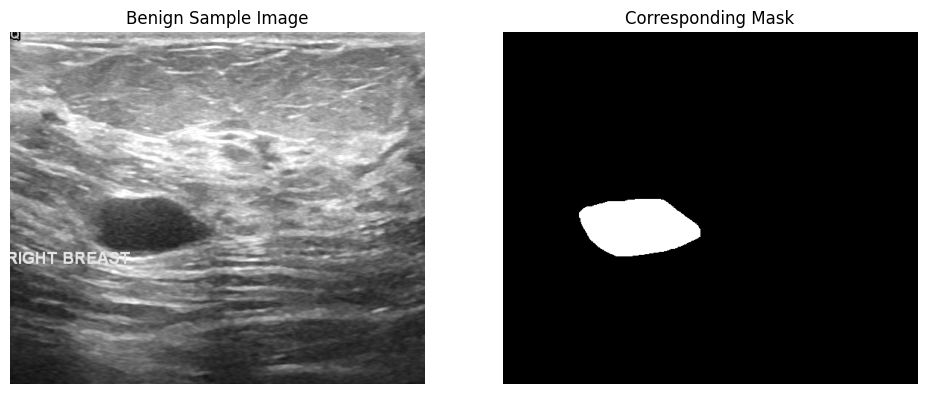

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Adjust this path to match your own Kaggle environment/dataset path.
# For example, if the dataset is in ../input/breast-ultrasound-images-dataset/
BASE_PATH = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"

# We'll keep our data in a dictionary: { 'benign': [], 'malignant': [], 'normal': [] }
# Each entry will be a list of tuples: (image_array, mask_array).
data = {
    'benign': [],
    'malignant': [],
    'normal': []
}

# Helper function to load images and masks
def load_images_and_masks(folder_path):
    """
    Given a folder path, returns a list of (image, mask) tuples.
    It assumes every image has a corresponding mask file with '_mask' appended before the extension.
    """
    # Gather all PNG files that are NOT masks
    all_files = os.listdir(folder_path)
    image_files = [f for f in all_files if f.endswith(".png") and "_mask" not in f]

    loaded_data = []
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        
        # Construct mask filename: 
        # e.g., if 'X.png' is the image, we expect 'X_mask.png' for the mask
        mask_file = img_file.replace(".png", "_mask.png")
        mask_path = os.path.join(folder_path, mask_file)

        # Read the image and mask (grayscale or color depending on your need)
        # Ultrasound is often grayscale, so let's do IMREAD_GRAYSCALE
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is not None and mask is not None:
            loaded_data.append((image, mask))
        else:
            print(f"Warning: Could not read image/mask for {img_file}")

    return loaded_data

# Loop through each subfolder and load data
for label in data.keys():
    folder = os.path.join(BASE_PATH, label)
    data[label] = load_images_and_masks(folder)

# Now let's print a summary
print("Dataset Summary")
print("---------------")
total_images = 0
for label in data.keys():
    count = len(data[label])
    total_images += count
    # Print basic shape info for the first sample (just to give an idea)
    if count > 0:
        sample_img, sample_mask = data[label][0]
        print(f"Class: {label}")
        print(f"  Number of samples: {count}")
        print(f"  Sample image shape: {sample_img.shape}")
        print(f"  Sample mask shape:  {sample_mask.shape}")
    else:
        print(f"Class: {label} - No images found.")

print("---------------")
print(f"Total images loaded: {total_images}")

# Optional: Display a small example of an image + mask
# Let's pick one from the 'benign' category (if it exists)
if len(data['benign']) > 0:
    sample_img, sample_mask = data['benign'][0]

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(sample_img, cmap='gray')
    plt.title("Benign Sample Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(sample_mask, cmap='gray')
    plt.title("Corresponding Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [2]:
from sklearn.model_selection import train_test_split

# Suppose you have a list of (image, mask) pairs for each class
benign_data = data['benign']  # List of (image, mask) tuples
malignant_data = data['malignant']
normal_data = data['normal']

# Combine them and create labels
X = benign_data + malignant_data + normal_data  # All image/mask pairs
y = ([0]*len(benign_data)) + ([1]*len(malignant_data)) + ([2]*len(normal_data)) 
# 0 = benign, 1 = malignant, 2 = normal (or whichever labeling scheme you prefer)

# First split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Then split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.15, stratify=y_trainval, random_state=42
)

print(f"Train size: {len(X_train)}")
print(f"Val size:   {len(X_val)}")
print(f"Test size:  {len(X_test)}")


Train size: 563
Val size:   100
Test size:  117


In [3]:
def preprocess_image(img, size=(224, 224)):
    # Resize
    img_resized = cv2.resize(img, size)
    # Normalize to 0-1
    img_normalized = img_resized / 255.0
    return img_normalized


In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img, size=(224, 224)):
    """
    Resizes the image to `size` and normalizes pixel values to [0,1].
    For grayscale images, expand dims to get shape (H, W, 1).
    """
    # Resize to the desired size
    img_resized = cv2.resize(img, size)

    # Convert to float and normalize to [0, 1]
    img_normalized = img_resized.astype(np.float32) / 255.0

    # If it's a single-channel image, expand dims to shape (224,224,1)
    if len(img_normalized.shape) == 2:
        img_normalized = np.expand_dims(img_normalized, axis=-1)

    return img_normalized


# Example label mapping
label_map = {
    'benign': 0,
    'malignant': 1,
    'normal': 2
}

X = []
y = []

# Iterate over each class label and its (image, mask) pairs
for label, pairs in data.items():
    for (img, mask) in pairs:
        # Preprocess the image
        processed_img = preprocess_image(img, size=(224, 224))
        
        X.append(processed_img)
        y.append(label_map[label])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (num_samples, 224, 224, 1) or (num_samples, 224, 224, 3)
print("y shape:", y.shape)  # (num_samples,)


# 1) Split train+val vs test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# 2) Split train vs val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.15,  # 15% of (train+val)
    stratify=y_trainval,
    random_state=42
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


X shape: (780, 224, 224, 1)
y shape: (780,)
Train size: 563
Validation size: 100
Test size: 117


In [9]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,        # rotate images by up to 20 degrees
    width_shift_range=0.1,    # shift horizontally by 10%
    height_shift_range=0.1,   # shift vertically by 10%
    zoom_range=0.2,           # zoom in/out by 20%
    horizontal_flip=True,     # flip horizontally
    fill_mode='nearest'       # fill in missing pixels
)

# For validation and test, we usually do NOT augment, just the same normalization
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

batch_size = 32

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=batch_size,
    shuffle=False
)


In [ ]:
# vgg downloaded from https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# For splitting data
from sklearn.model_selection import train_test_split

# For data augmentation and model building in Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras import layers, models, optimizers

################################################################################
# 1. LOAD & PREPROCESS DATA
################################################################################

# Suppose you have a dictionary named `data` with keys: 'benign', 'malignant', 'normal'.
# Each entry is a list of (image, mask) tuples, but for classification, we only need the image.
# Example: data['benign'] = [(img1, mask1), (img2, mask2), ... ]

# Map each label to a numeric class (0, 1, 2). Adjust if you prefer a different order.
label_map = {
    'benign': 0,
    'malignant': 1,
    'normal': 2
}

def preprocess_image(img, size=(224, 224)):
    """
    1) Resize to `size`.
    2) Normalize to [0,1].
    3) Convert grayscale -> 3 channels for VGG (if needed).
    """
    # Resize
    img_resized = cv2.resize(img, size)

    # Normalize
    img_resized = img_resized.astype(np.float32) / 255.0

    # If single-channel (H,W), expand to (H,W,1) then tile to (H,W,3)
    if len(img_resized.shape) == 2:  # grayscale
        img_resized = np.expand_dims(img_resized, axis=-1)  # (H, W, 1)
        img_resized = np.tile(img_resized, (1, 1, 3))       # (H, W, 3)

    return img_resized

# Gather images (X) and labels (y)
X = []
y = []

for label, pairs in data.items():
    for (img, mask) in pairs:
        processed_img = preprocess_image(img, size=(224, 224))
        X.append(processed_img)
        y.append(label_map[label])

X = np.array(X)
y = np.array(y)

print("Data shape:", X.shape, "Labels shape:", y.shape)
# Example: (780, 224, 224, 3)  (780,)

################################################################################
# 2. SPLIT DATA INTO TRAIN, VAL, TEST
################################################################################

# First, separate out a test set (15%), then a validation set (15% of the remainder)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.15, stratify=y_trainval, random_state=42
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

################################################################################
# 3. DATA AUGMENTATION
################################################################################

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation and test, we typically only do rescaling (already normalized in preprocess)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

batch_size = 32

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=batch_size,
    shuffle=False
)

################################################################################
# 4. BUILD VGG16 & VGG19 MODELS (TRANSFER LEARNING)
################################################################################

def build_vgg16_model(input_shape=(224, 224, 3), num_classes=3, freeze_until=15):
    """
    Build a VGG16 model (pretrained on ImageNet) for multi-class classification.
    freeze_until: number of layers to freeze in the base model (set to None to unfreeze all).
    """
    local_weights_path = "/kaggle/input/vgg16/keras/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    
    base_model = VGG16(
        weights=local_weights_path,
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the first `freeze_until` layers
    if freeze_until is not None:
        for layer in base_model.layers[:freeze_until]:
            layer.trainable = False
    
    # Build classification head
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def build_vgg19_model(input_shape=(224, 224, 3), num_classes=3, freeze_until=17):
    """
    Build a VGG19 model (pretrained on ImageNet) for multi-class classification.
    freeze_until: number of layers to freeze in the base model (set to None to unfreeze all).
    """
    local_weights_path = "/kaggle/input/vgg16/keras/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    
    base_model = VGG16(
        weights=local_weights_path,
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the first `freeze_until` layers
    if freeze_until is not None:
        for layer in base_model.layers[:freeze_until]:
            layer.trainable = False
    
    # Build classification head
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

################################################################################
# 5. TRAIN & EVALUATE VGG16
################################################################################

vgg16_model = build_vgg16_model(input_shape=(224, 224, 3), num_classes=3, freeze_until=15)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n=== VGG16 Model Summary ===")
vgg16_model.summary()

# Train
history_vgg16 = vgg16_model.fit(
    train_generator,
    epochs=5,  # increase for better results
    validation_data=val_generator
)

# Evaluate on test set
test_loss_vgg16, test_acc_vgg16 = vgg16_model.evaluate(test_generator)
print("VGG16 Test Accuracy:", test_acc_vgg16)

################################################################################
# 6. TRAIN & EVALUATE VGG19
################################################################################

vgg19_model = build_vgg19_model(input_shape=(224, 224, 3), num_classes=3, freeze_until=17)
vgg19_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n=== VGG19 Model Summary ===")
vgg19_model.summary()

# Train
history_vgg19 = vgg19_model.fit(
    train_generator,
    epochs=5,  # increase for better results
    validation_data=val_generator
)

# Evaluate on test set
test_loss_vgg19, test_acc_vgg19 = vgg19_model.evaluate(test_generator)
print("VGG19 Test Accuracy:", test_acc_vgg19)

################################################################################
# 7. COMPARE RESULTS
################################################################################

print("\nFinal Results:")
print(f"VGG16 Test Accuracy: {test_acc_vgg16:.4f}")
print(f"VGG19 Test Accuracy: {test_acc_vgg19:.4f}")

################################################################################
# 8. OPTIONAL: CONFUSION MATRIX & CLASSIFICATION REPORT
################################################################################
from sklearn.metrics import confusion_matrix, classification_report

# Predict classes
preds_vgg16 = vgg16_model.predict(test_generator)
pred_classes_vgg16 = np.argmax(preds_vgg16, axis=1)
true_classes = test_generator.classes  # y_test in the same order as the generator

cm_vgg16 = confusion_matrix(true_classes, pred_classes_vgg16)
print("\n=== VGG16 Confusion Matrix ===")
print(cm_vgg16)

print("\n=== VGG16 Classification Report ===")
print(classification_report(true_classes, pred_classes_vgg16, target_names=["Benign","Malignant","Normal"]))

# Similarly for VGG19
preds_vgg19 = vgg19_model.predict(test_generator)
pred_classes_vgg19 = np.argmax(preds_vgg19, axis=1)

cm_vgg19 = confusion_matrix(true_classes, pred_classes_vgg19)
print("\n=== VGG19 Confusion Matrix ===")
print(cm_vgg19)

print("\n=== VGG19 Classification Report ===")
print(classification_report(true_classes, pred_classes_vgg19, target_names=["Benign","Malignant","Normal"]))


Data shape: (780, 224, 224, 3) Labels shape: (780,)
Train size: 563
Val size: 100
Test size: 117

=== VGG16 Model Summary ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 13,502,979 (51.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 231s 13s/step - accuracy: 0.3982 - loss: 2.0183 - val_accuracy: 0.5600 - val_loss: 1.0026
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 228s 13s/step - accuracy: 0.5000 - loss: 1.0788 - val_accuracy: 0.5600 - val_loss: 0.9722
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 274s 13s/step - accuracy: 0.5289 - loss: 1.0347 - val_accuracy: 0.5600 - val_loss: 0.9740
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 239s 13s/step - accuracy: 0.5740 - loss: 0.9889 - val_accuracy: 0.5600 - val_loss: 0.9739
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 250s 13s/step - accuracy: 0.5988 - loss: 0.9560 - val_accuracy: 0.5600 - val_loss: 0.9858
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 0.5683 - loss: 0.9759
VGG16 Test Accuracy: 0.5641025900840759

=== VGG19 Model Summary ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 8,783,363 (33.51 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 201s 11s/step - accuracy: 0.4527 - loss: 2.8939 - val_accuracy: 0.6600 - val_loss: 0.7862
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 202s 11s/step - accuracy: 0.6856 - loss: 0.7509 - val_accuracy: 0.7100 - val_loss: 0.7204
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 199s 11s/step - accuracy: 0.6954 - loss: 0.7558 - val_accuracy: 0.7300 - val_loss: 0.7257
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 201s 11s/step - accuracy: 0.7407 - loss: 0.6041 - val_accuracy: 0.7100 - val_loss: 0.7120
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 201s 11s/step - accuracy: 0.7754 - loss: 0.5529 - val_accuracy: 0.7700 - val_loss: 0.6481
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 8s/step - accuracy: 0.7811 - loss: 0.5790
VGG19 Test Accuracy: 0.752136766910553

Final Results:
VGG16 Test Accuracy: 0.5641
VGG19 Test Accuracy: 0.7521
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 8s/step


AttributeError: 'NumpyArrayIterator' object has no attribute 'classes'